In [513]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

% matplotlib inline

In [514]:
tabela_final = pd.read_csv('tabela_final_prod.csv')
#tabela_final = pd.read_csv('tabela_final_dev.csv')

In [515]:
columns = [column for column in tabela_prod.columns if column != 'municipio']

for column in tabela_prod[columns]:
    tabela_prod[column] = tabela_prod[column].replace('-', np.nan)
    tabela_prod[column] = tabela_prod[column].astype('float64')

In [516]:
tabela_final = tabela_final.loc[tabela_final.municipio != 'Fernando de Noronha']
# tabela_final = tabela_final.loc[tabela_final.municipio != 'Recife']

for column in tabela_final.columns:
    if 'total' in column:
        tabela_final.drop(column, axis=1, inplace=True)

In [517]:
tabela_final.set_index('municipio',inplace=True)
#tabela_final = tabela_final.fillna(0)

In [518]:
not_in_columns = ['pop','taxa_homicidio','pessoas_de_10_anos_ou_mais_de_idade_ocupadas_na_semana_de_referencia_total',\
                  'domicilios_particulares_permanentes_por_situacao_do_domicilio_rural__destino_do_lixo(%)_coletado',\
                 'domicilios_particulares_permanentes_por_situacao_do_domicilio_rural__destino_do_lixo(%)_queimado_ou_enterrado',\
                 'domicilios_particulares_permanentes_por_situacao_do_domicilio_rural__destino_do_lixo(%)_outra_forma_(1)',\
                 'domicilios_particulares_permanente_por_situacao_do_domicilio_rural__tipo_de_esgotamento_sanitario(%)_rede_geral',\
                 'domicilios_particulares_permanente_por_situacao_do_domicilio_rural__tipo_de_esgotamento_sanitario(%)_fossa_septica',\
                 'domicilios_particulares_permanente_por_situacao_do_domicilio_rural__tipo_de_esgotamento_sanitario(%)_outra_forma_(1)',\
                 'domicilios_particulares_permanente_por_situacao_do_domicilio_rural__sem_instalacao_sanitaria(%)']

In [521]:
which_columns = []
x = tabela_final['taxa_homicidio'].values
for column in tabela_final.columns:
    if (column not in not_in_columns):
        y = tabela_final[column].values
        model = linregress(x,y)
        if (model.pvalue <= 0.0000000001):
            which_columns.append(column)

In [523]:
#2 0.00000000005
#3 0.00000000006
#4 0.000000000082
#5 0.00000000009
#7 0.0000000001

print(len(which_columns))
which_columns

10


['pessoas_de_10_anos_ou_mais_de_idade_20_anos_ou_mais_taxa_de_alfabetizacao_(%)',
 'valor_do_rendimento_nominal_mediano_mensal_do_trabalho_principal_das_pessoas_de_10_anos_ou_mais_de_idade_ocupadas_na_semana_de_referencia_com_rendimento_no_trabalho_principal_(r$)__posicao_na_ocupacao_no_trabalho_principal_conta_propria_categoria_do_emprego_no_trabalho_principal_outros_sem_carteira_de_trabalho_assinada_(1)',
 'domicilios_particulares_permanentes_classes_de_salario_minimo_(%)_de_2_a_3',
 'domicilios_particulares_permanentes_classes_de_salario_minimo_(%)_mais_de_3',
 'populacao_situacao_do_domicilio_(%)_urbana',
 'populacao_situacao_do_domicilio_(%)_rural',
 'populacao_proporcao_de_pessoas_naturais_dos_municipios_(%)',
 'proporcao_de_pessoas_de_15_anos_ou_mais_de_idade_com_menos_de_4_anos_de_estudo_(%)_por_sexo_homem',
 'proporcao_de_domicilios_com_criancas_de_ate_14_anos_de_idade_com_rendimento_domiciliar_per_capita_de_ate_1/2_salario_minimo_e_com_responsavel_com_menos_de_4_anos_de_estud

## Normalização e scatter plot

> Normalização das colunas selecionadas e scatter plot delas

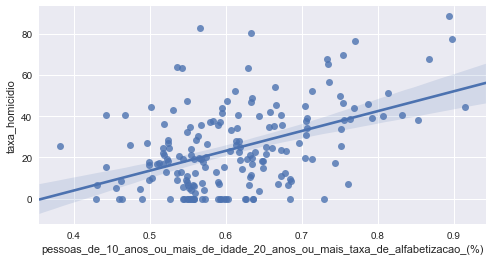

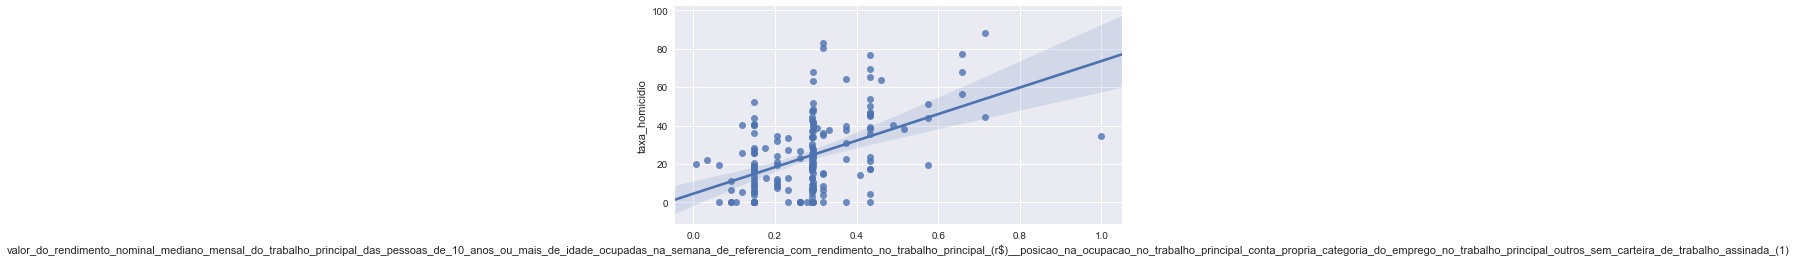

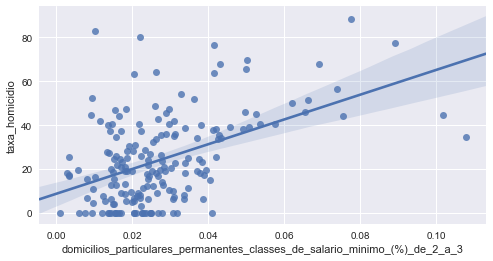

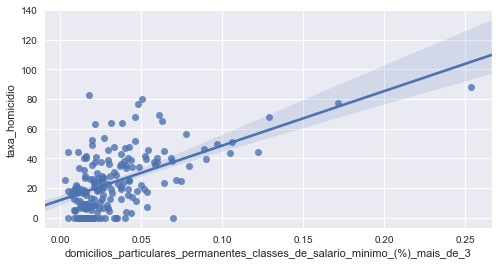

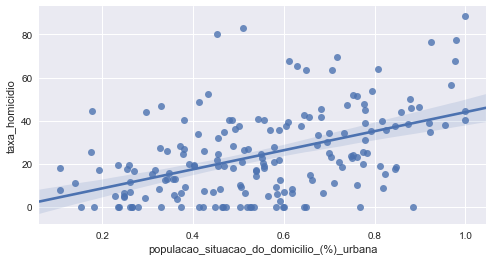

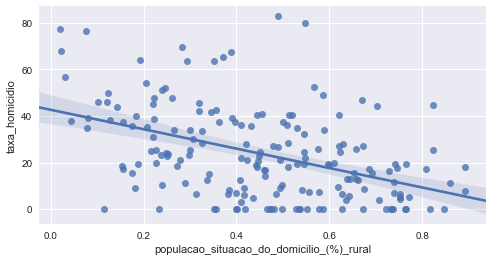

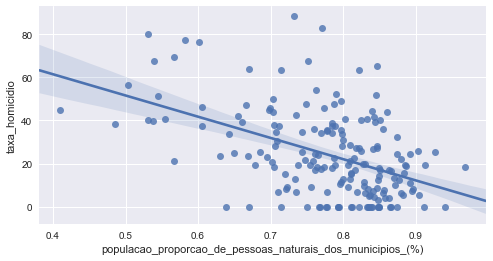

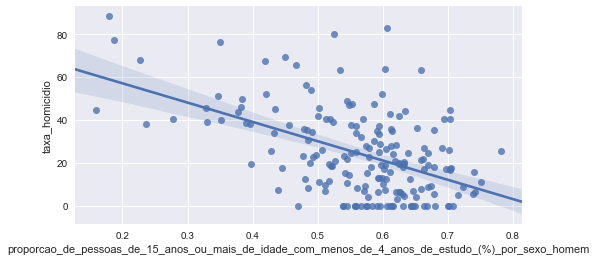

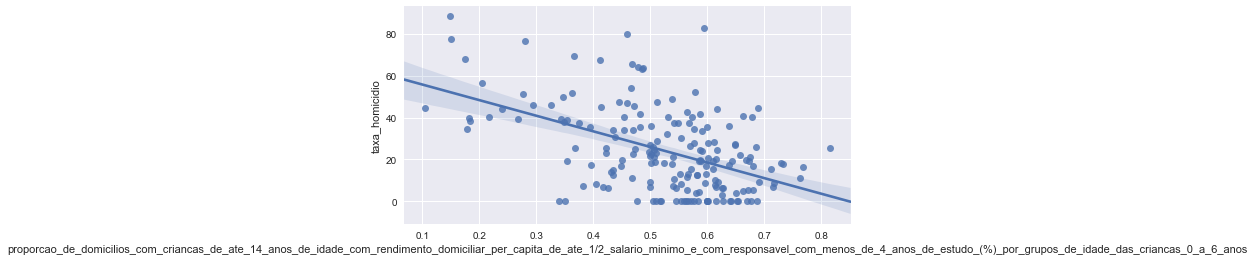

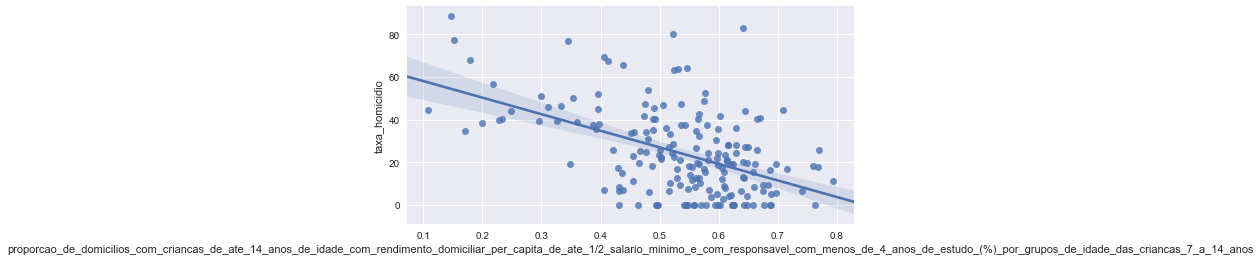

In [526]:
df = tabela_final.copy()
for column in which_columns:
    if ('(%)' not in column):
#         print(column)
#         df[column] = df[column].apply(lambda x: (x - df[column].mean()) / df[column].std())  #normalizacao zscore
        df[column] = df[column].apply(lambda x: x * 100000 / df['pop'])
        df[column] = df[column].apply(lambda x: (x - df[column].min()) / (df[column].max() - df[column].min()) ) #normalizacao min-max
#         df[column] = df[column].apply(lambda x: np.log10(x))
    else:
        df[column] = df[column].apply(lambda x: x/100)
    #ax = df.plot.scatter(x=column, y='taxa_homicidio')
    plt.subplots(figsize=(8,4))
    ax = sns.regplot(column, 'taxa_homicidio',data=df.loc[df[column] > 0])

In [527]:
from sklearn.cluster import KMeans

skip_columns = [
    'pessoas_de_10_anos_ou_mais_de_idade_grupos_de_anos_de_estudo_sem_instrucao_e_menos_de_1_ano'
]
clusterizable_columns = [column for column in which_columns if column not in skip_columns]

df = df.replace([np.inf, -np.inf, '-'], np.nan).dropna()
model = KMeans(n_clusters=3).fit(df.dropna()[clusterizable_columns].values)
model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

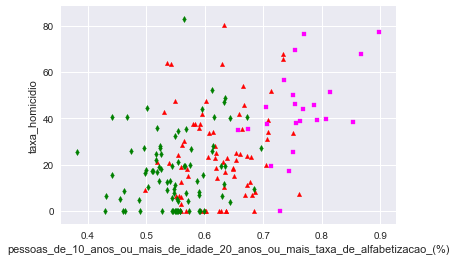

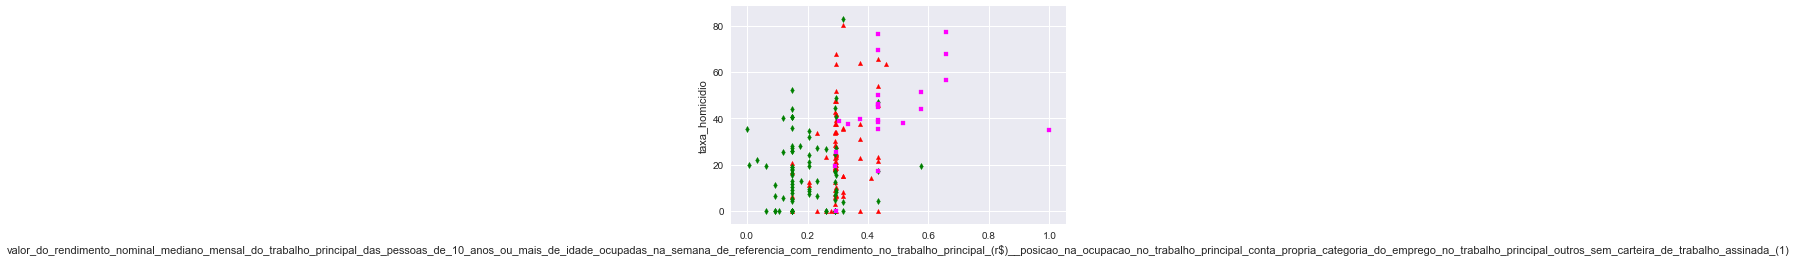

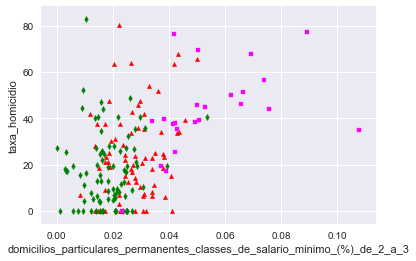

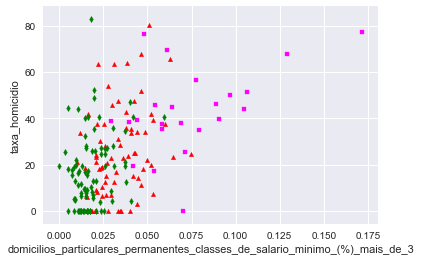

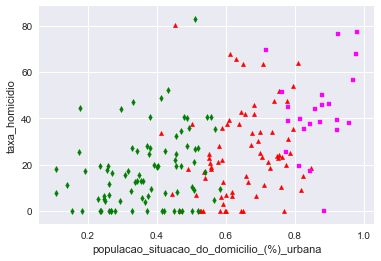

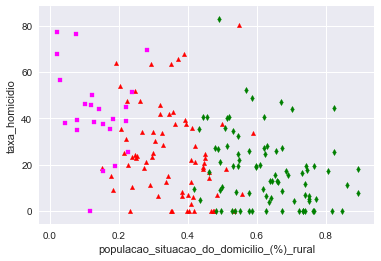

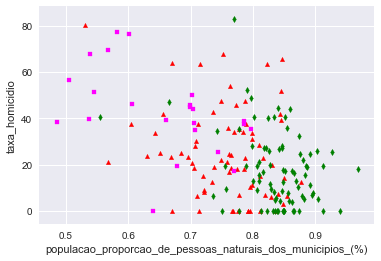

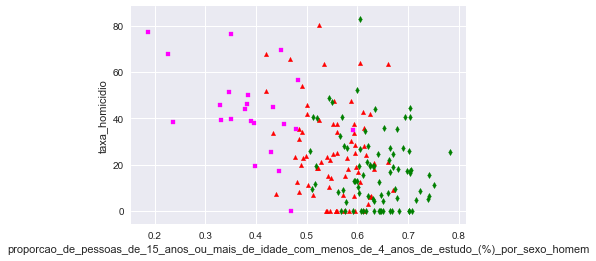

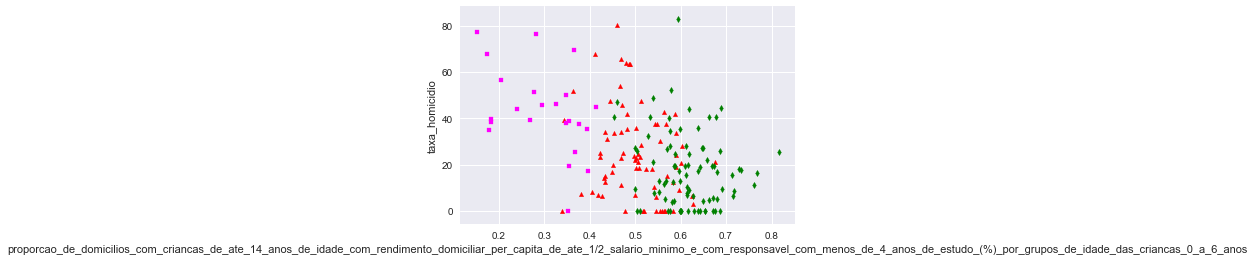

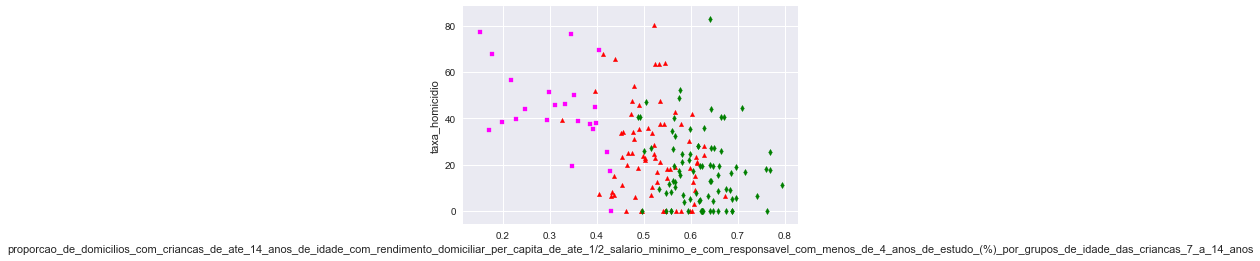

In [528]:


for column in clusterizable_columns:
    clusters = np.asarray(['c{}'.format(a+1) for a in model.labels_],dtype='object')
    ax = df.dropna()[clusters=='c1'].plot.scatter(x=column,y='taxa_homicidio',marker='^',color='red')
    df.dropna()[clusters=='c2'].plot.scatter(x=column,y='taxa_homicidio',marker='d', color='green',ax=ax)
    df.dropna()[clusters=='c3'].plot.scatter(x=column,y='taxa_homicidio',marker='s',color='magenta', ax=ax)
    #df.dropna()[clusters=='c4'].plot.scatter(x=column,y='taxa_homicidio',marker='*',color='blue', ax=ax)
    # c1, c2, c3 = model.cluster_centers_
    # ax.scatter(*c1,color='red',marker='^',s=50)
    # ax.scatter(*c2,marker='d',color='green',s=50)
    # ax.scatter(*c3,marker='s',color='magenta',s=50)